In [1]:
import numpy as np
import pandas as pd
import string
import re
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

In [2]:
## Define Problem: 

In [3]:
## Collect Text Data (External)

In [4]:
## Import Training Data (Text Corpus):
with open('training-text.txt', encoding='utf-8') as input_file:
    training_text = input_file.read()
    
print(training_text)

Music theory is the study of the practices and possibilities of music. The Oxford Companion to Music describes three interrelated uses of the term "music theory". The first is the "rudiments", that are needed to understand music notation (key signatures, time signatures, and rhythmic notation); the second is learning scholars' views on music from antiquity to the present; the third is a sub-topic of musicology that "seeks to define processes and general principles in music". The musicological approach to theory differs from music analysis "in that it takes as its starting-point not the individual work or performance but the fundamental materials from which it is built."[1]

Music theory is frequently concerned with describing how musicians and composers make music, including tuning systems and composition methods among other topics. Because of the ever-expanding conception of what constitutes music (see Definition of music), a more inclusive definition could be the consideration of any

In [5]:
## Clean Training Data:
## Remove Punctuation Characters:
training_text = training_text.translate(str.maketrans('', '', string.punctuation))
## Remove Line Breaks:
training_text = training_text.replace('\n','')
## Remove Numerical Characters:
training_text = re.sub(r'[0-9]+', '', training_text)
## Lowercase Characters:
training_text = training_text.lower()
## Split String into List:
training_text_word_list = training_text.split()
## Remove Stopwords:
with open('stopwords.txt', encoding='utf-8') as input_file:
    stopword_list = input_file.read().split()
training_text_word_list = [i for i in training_text_word_list if i not in stopword_list]

print(training_text_word_list)

['music', 'theory', 'study', 'practices', 'possibilities', 'music', 'oxford', 'companion', 'music', 'describes', 'three', 'interrelated', 'uses', 'term', 'music', 'theory', 'first', 'rudiments', 'needed', 'understand', 'music', 'notation', 'key', 'signatures', 'time', 'signatures', 'rhythmic', 'notation', 'second', 'learning', 'scholars', 'views', 'music', 'antiquity', 'present', 'third', 'subtopic', 'musicology', 'seeks', 'define', 'processes', 'general', 'principles', 'music', 'musicological', 'approach', 'theory', 'differs', 'music', 'analysis', 'takes', 'startingpoint', 'individual', 'work', 'performance', 'fundamental', 'materials', 'builtmusic', 'theory', 'frequently', 'concerned', 'describing', 'musicians', 'composers', 'make', 'music', 'including', 'tuning', 'systems', 'composition', 'methods', 'among', 'topics', 'everexpanding', 'conception', 'constitutes', 'music', 'see', 'definition', 'music', 'inclusive', 'definition', 'could', 'consideration', 'sonic', 'phenomena', 'includ

In [6]:
## Prepare Training Data
## Construct the Dataset via 'skip-gram' (predicts words within a certain range before and after the current word in the same sentence)
# Note: Context Word Window Size could be 50, 100, 200, etc.
context_word_window_size = 25 # Context Word is within N words before AND N words after the primary word being reviewed in the training text
number_negative_samples = 10 # For each primary word we include N examples that are not within it's context

dataset_list = []

# Iterate over each word in the Training Data
for index, primary_word in enumerate(training_text_word_list[context_word_window_size-1:-context_word_window_size]):
    # Iterate over each context word within the context word window size around the primary word
    context_words_list = [context_word for context_word in training_text_word_list[index:index+2*context_word_window_size-1] if context_word != primary_word]
    for context_word in context_words_list:
        # Select Negative Examples: words NOT in the context
        dataset_list.append([primary_word, context_word, 1])
        negative_sample_list = np.random.choice([word for word in training_text_word_list[context_word_window_size-1:-context_word_window_size] if word != primary_word and word not in context_word], number_negative_samples)
        for negative_sample in negative_sample_list:
            # Add a training row
            dataset_list.append([primary_word, negative_sample, 0])
            
df = pd.DataFrame(columns=['primary_word', 'context_word', 'label'], data=dataset_list) # Labels containing the Primary Word will be equal to 1, else 0.
words = np.intersect1d(df.context_word, df.primary_word)
df = df[(df.primary_word.isin(words)) & (df.context_word.isin(words))].reset_index(drop=True)

In [7]:
## Run Word2Vec:

In [8]:
## Define Functions:
## Data Normalization:
def normalize_data(data):
    row_norms = np.sqrt((data.values**2).sum(axis=1)).reshape(-1,1)
    return data.divide(row_norms, axis='index')

def sigmoid_function(value, scale=1): # Squashing Function with range of (0, 1); regardless of numerical input (-/+) the output will be between 0 and 1.
    value = 1 / (1 + np.exp(-scale*value))
    return value

def update_embeddings(df, primary_embeddings, context_embeddings, learning_rate, debug=False):
    ## Calculate Differences: the difference between each pair of vectors; update in the direction of differences to bridge gaps that should be bridged and widen gaps that should be further from each other
    primary_embeddings_primary = primary_embeddings.loc[df.primary_word].values
    context_embeddings_context = context_embeddings.loc[df.context_word].values
    differences = context_embeddings_context - primary_embeddings_primary
    ## Calculate Score: via Sigmoid Function: (https://machinelearningmastery.com/a-gentle-introduction-to-sigmoid-function/)
    dot_prods = np.sum(primary_embeddings_primary * context_embeddings_context, axis=1)
    scores = sigmoid_function(dot_prods)
    ## Calculate Errors: magnitude of how aggressive we want to be; updates proportional to what the error currently is
    errors = (df.label - scores).values.reshape(-1,1)
    ## Calculate Vector Updates:
    updates = differences*errors*learning_rate # Learning Rate: how quickly you want the algorithm to complete
    updates_df = pd.DataFrame(data=updates)
    updates_df['primary_word'] = df.primary_word
    updates_df['context_word'] = df.context_word
    updates_df_primary = updates_df.groupby('primary_word').sum()
    updates_df_context = updates_df.groupby('context_word').sum()
    
    if debug:
        plot_words(debug)
    
    # Apply Updates:
    primary_embeddings += updates_df_primary.loc[primary_embeddings.index]
    context_embeddings -= updates_df_context.loc[context_embeddings.index]
    # Normalize Embeddings:
    primary_embeddings = normalize_data(primary_embeddings)
    context_embeddings = normalize_data(context_embeddings)
    
    return primary_embeddings, context_embeddings

def plot_words(debug):
    plt.figure(figsize=(8,4))
    
    plt.subplot(1,2,1)
    lim_main_first = primary_embeddings.loc[[debug[0]]]
    lim_main_second = primary_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main_first[0], lim_main_first[1], color='r')
    plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_first.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_main_second[0], lim_main_second[1], color='r')
    plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_second.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(primary_embeddings.loc[debug[0]], primary_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    
    t = np.arange(0, 3.14*2+0.1, 0.1)
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    
    plt.subplot(1,2,2)
    lim_main = primary_embeddings.loc[[debug[0]]]
    lim_context = context_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main[0], lim_main[1], color='r')
    plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_context[0], lim_context[1], color='b')
    plt.arrow(0,0,float(lim_context[0]), float(lim_context[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_context.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(primary_embeddings.loc[debug[0]], context_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')
    plt.show()

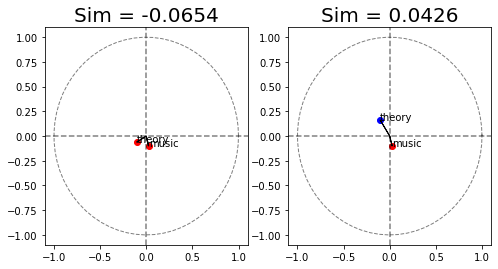

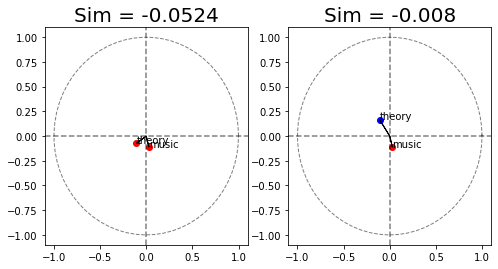

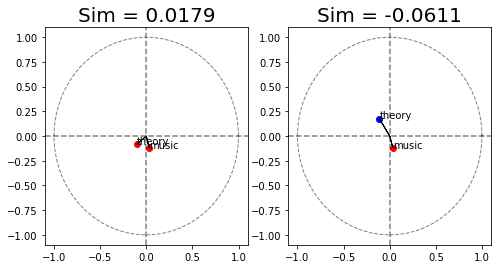

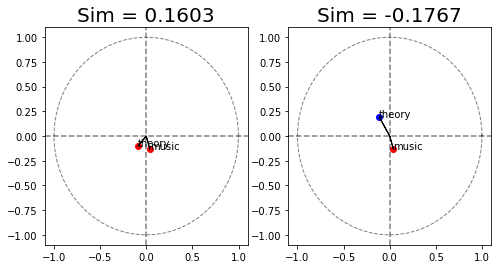

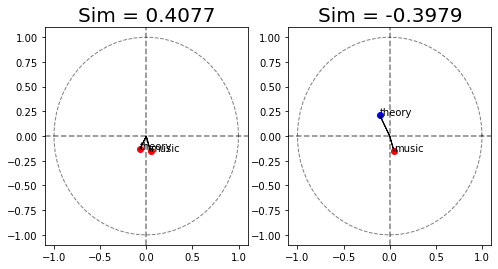

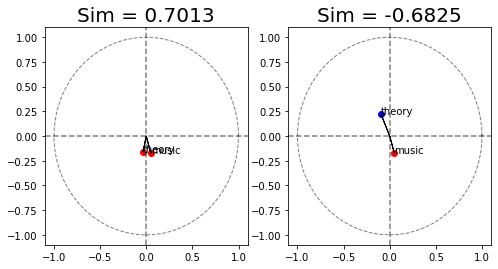

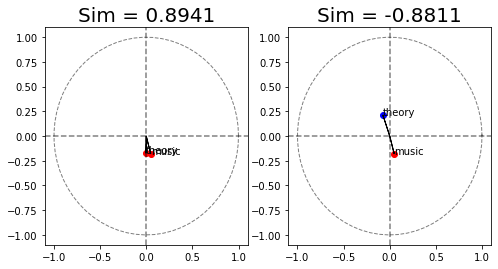

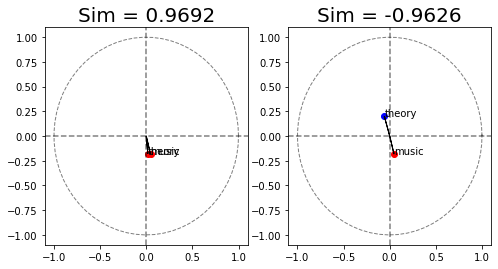

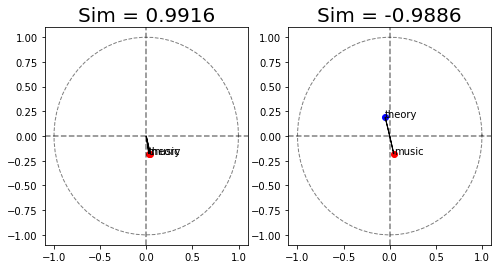

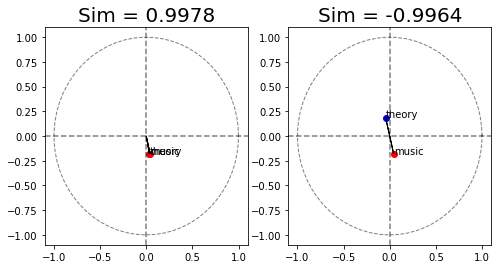

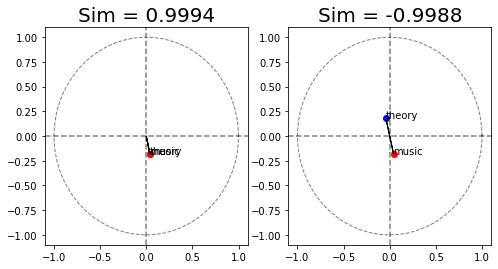

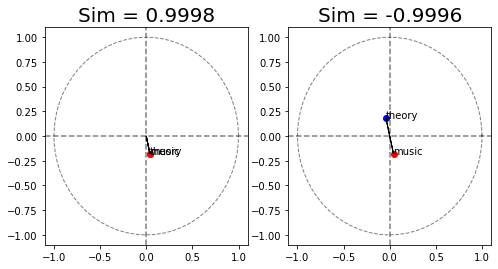

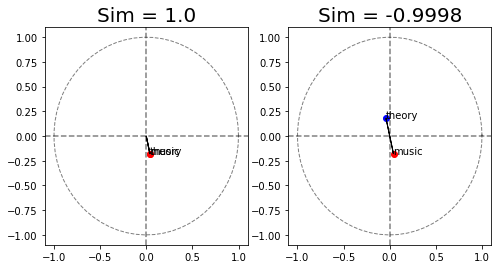

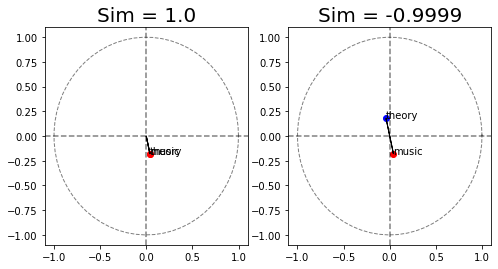

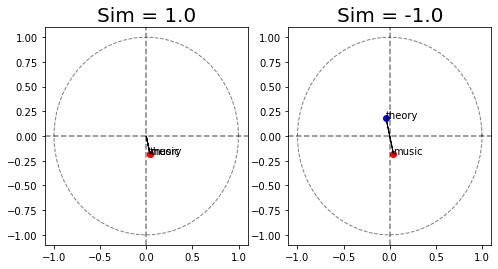

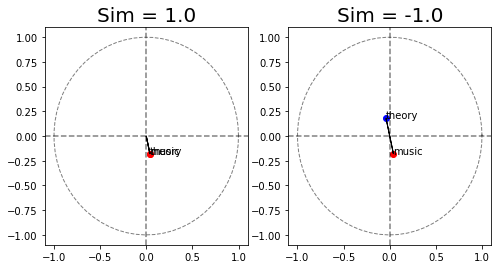

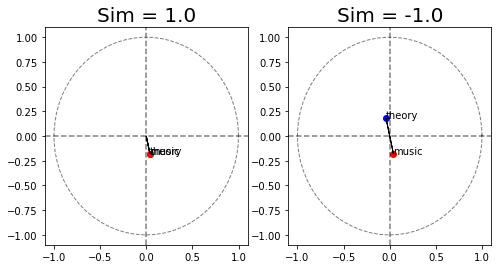

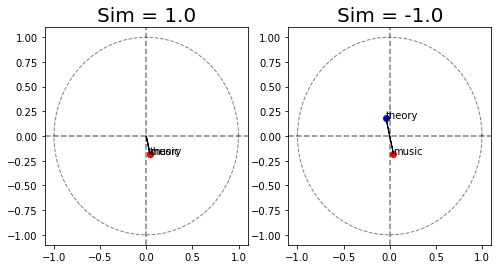

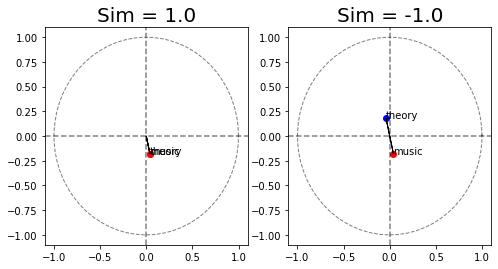

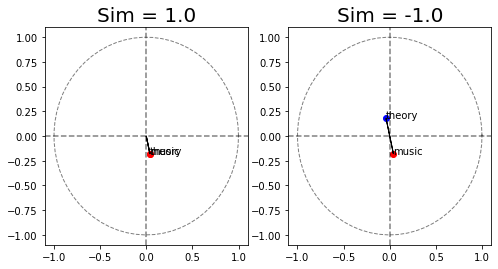

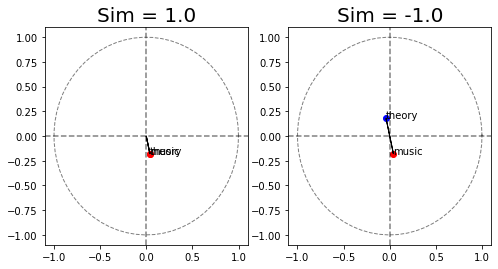

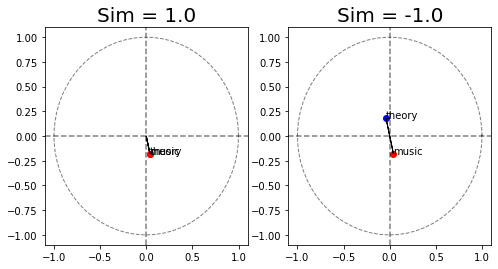

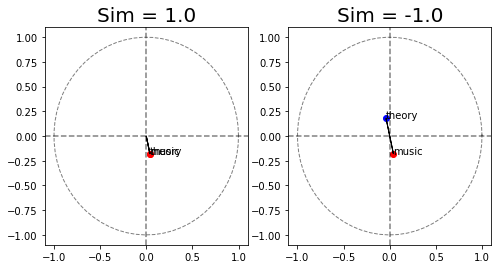

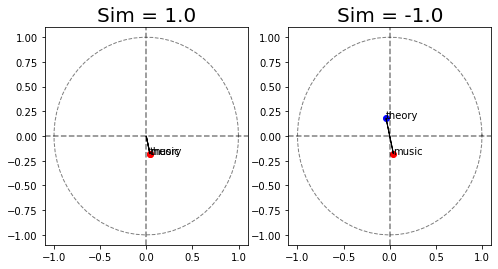

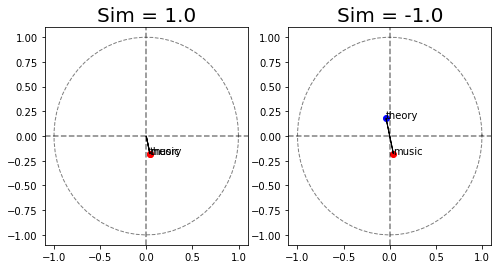

In [9]:
## Run Word2Vec
EMBEDDING_SIZE = 128

primary_embeddings = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((primary_embeddings**2).sum(axis=1)).reshape(-1,1)
primary_embeddings = primary_embeddings / row_norms

context_embeddings = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((context_embeddings**2).sum(axis=1)).reshape(-1,1)
context_embeddings = context_embeddings / row_norms

primary_embeddings = pd.DataFrame(data=primary_embeddings, index=words)
context_embeddings = pd.DataFrame(data=context_embeddings, index=words)

## Plot Cosine Similarities (Sample of 25):
## Reference for Sample Primary Word and Context Word combination, e.g: "Music" and "Theory"
for _ in range(25):
    primary_embeddings, context_embeddings = update_embeddings(df, primary_embeddings, context_embeddings, 0.1, ['music', 'theory'])

In [10]:
## Calculate Similarities: 
word_similarity_list = []
for word1 in words:
    for word2 in words:
        if word1 != word2:
            sim = 1 - cosine(primary_embeddings.loc[word1], primary_embeddings.loc[word2])
            word_similarity_list.append((word1,word2,sim))
            

word_similarity_df = pd.DataFrame(word_similarity_list, columns=['Primary Word','Context Word','Similarity Score']) # Create DataFrame
word_similarity_df['Similarity Score'] = word_similarity_df['Similarity Score'].astype(str) # Convert all columns to string
cross_column_duplicates = word_similarity_df.T.apply(sorted).T.duplicated()
word_similarity_df = word_similarity_df[~cross_column_duplicates]
word_similarity_df = word_similarity_df.sort_values(by=['Similarity Score'], ascending=False)#.head(100)

In [11]:
word_similarity_df.sort_values(by=['Similarity Score'], ascending=False).head(100)

,Primary Word,Context Word,Similarity Score
244449,systems,tuning,0.9999999999831252
158293,music,theory,0.9999999999814537
25744,became,centuries,0.9999999999745837
123380,instruments,oral,0.9999999999735543
53131,convierten,experiencias,0.9999999999725199
177571,oral,traditions,0.9999999999722127
171052,nueve,regreso,0.9999999999715241
2094,abstract,tuning,0.9999999999684137
159916,musicmaking,traditions,0.9999999999681568
195743,practical,theory,0.9999999999679982


In [12]:
## Visualize Embeddings
from sklearn.decomposition import PCA

In [13]:
pca = PCA(n_components=2)
transf_embeddings = pca.fit_transform(primary_embeddings.values)
words_used = primary_embeddings.index
print(words_used)

Index(['abducciones', 'abordar', 'absolute', 'abstract', 'academia',
       'acoustics', 'act', 'actual', 'ad', 'addition',
       ...
       'written', 'yokohama', '¿cuándo', '¿los', '¿por', '¿quién', '¿qué',
       'θεωρία', '日本', '日本国'],
      dtype='object', length=536)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 26412 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 22269 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 26085 missing from current font.
  font.set_text(s, 0, flags=flags)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 26412 missing from cur

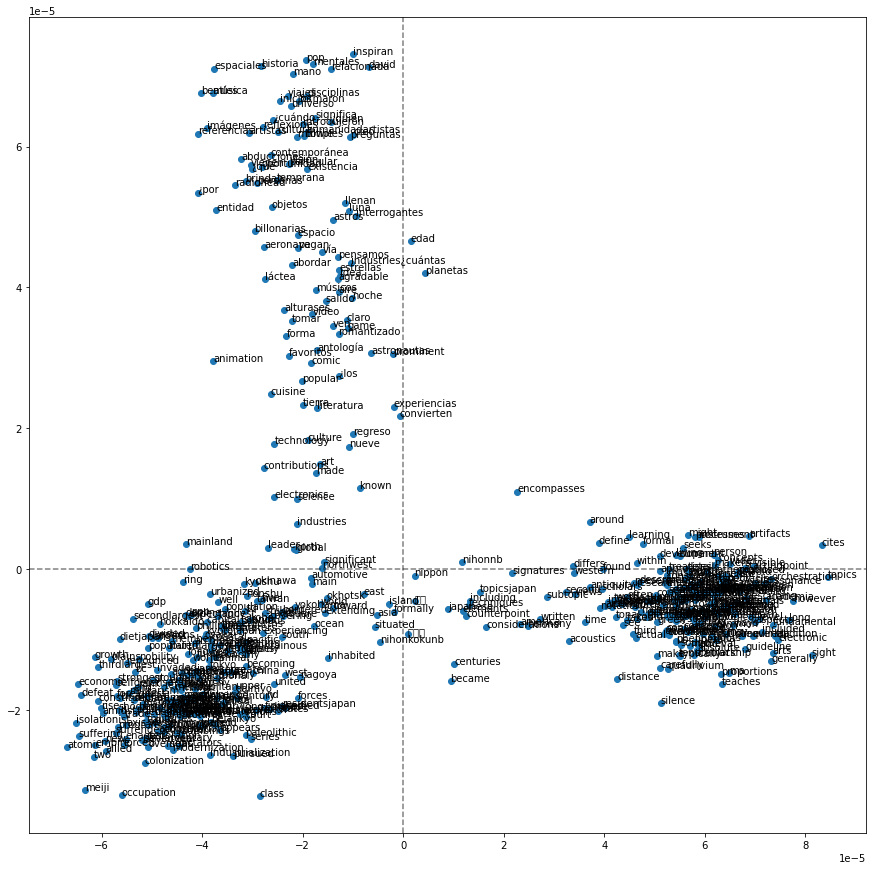

In [14]:
## Resize Plot:

plt.figure(figsize=(15,15))
plt.scatter(transf_embeddings[:,0], transf_embeddings[:,1])
for idx,row in enumerate(transf_embeddings):
    plt.text(row[0], row[1], str(words_used[idx]))
plt.axvline(0, color='k', linestyle='--', alpha=0.5)
plt.axhline(0, color='k', linestyle='--', alpha=0.5)